In [1]:
import numpy as np  # Matrix computations
import matplotlib.pyplot as plt  # Plotting
plt.rc('figure', figsize=(13, 7))  # Setting plot size
from IPython.display import display, Markdown  # Display cells with dynamic content

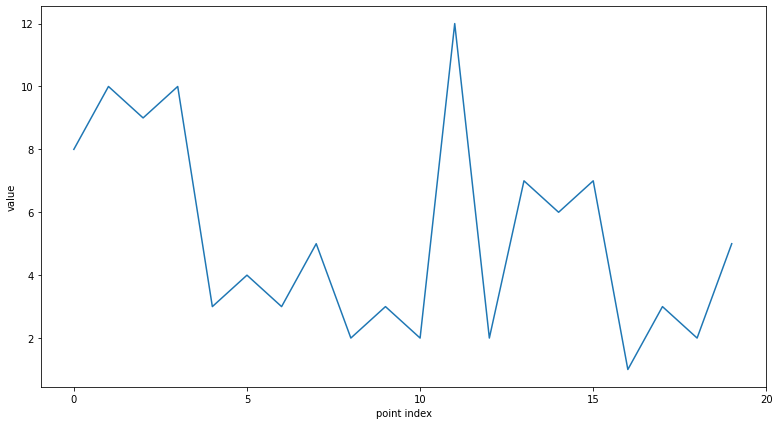

In [2]:
numlevels = 12
data = [8, 10, 9, 10, 3, 4, 3, 5, 2, 3, 2, 12, 2, 7, 6, 7, 1, 3, 2, 5]

plt.plot(data)
plt.ylabel('value')
plt.xlabel('point index')
plt.xticks([0, 5, 10, 15, 20])
plt.show()

In [3]:
transfers = []
for i, d in enumerate(data[:-1]):
  transfers.append((d, data[i+1]))

transfer_counts = {}
for t in transfers:
  if t in transfer_counts:
    transfer_counts[t] += 1
  else:
    transfer_counts[t] = 1

In [4]:
# Tables are made with text where cells are separated by |
table_rows = [ '| From\\To | ' + ' | '.join([str(n + 1) for n in range(numlevels)]),
'| --: '*(numlevels + 1) + '|' ]
for m in reversed(range(numlevels)):
  row = '| **' + str(m+1) + '** |'
  for n in range(numlevels):
    if m == n:
      row += ' X |'
    elif (m+1, n+1) in transfer_counts:
      row += ' ' + str(transfer_counts[(m+1, n+1)]) + '|'
    else:
      row += ' |'
  table_rows.append(row)

table = '\n'.join(table_rows)
display(Markdown(table))

| From\To | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12
| --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| **12** | | 1| | | | | | | | | | X |
| **11** | | | | | | | | | | | X | |
| **10** | | | 1| | | | | | 1| X | | |
| **9** | | | | | | | | | X | 1| | |
| **8** | | | | | | | | X | | 1| | |
| **7** | 1| | | | | 1| X | | | | | |
| **6** | | | | | | X | 1| | | | | |
| **5** | | 1| | | X | | | | | | | |
| **4** | | | 1| X | | | | | | | | |
| **3** | | 2| X | 1| 1| | | | | | | |
| **2** | | X | 1| | 1| | 1| | | | | 1|
| **1** | X | | 1| | | | | | | | | |

In [5]:
sign = lambda x: 1 if x > 0 else -1 if x < 0 else 0  # Defines sign (or signum) function

def make_droplets(data: list, direction: int) -> list:
  assert direction != 0
  direction = sign(direction)
  droplets = []
  taken_peaks = []
  for i, start in enumerate(data[:-1]):
    if sign(data[i + 1] - start) == direction:
      drop = { 'from': start, 'points': [(i, start)]}
      current_d = start
      for j in range(i+1, len(data)):
        if (data[j] - current_d) * direction >= 0:  # Fall on the next line
          # This points to details of a previous drop to fall on this line, or -1 if this is the first one
          taken_index = next((i for i, x in enumerate(taken_peaks) if x['index'] == j), -1)
          old_intercept = taken_peaks[taken_index]['intercept'] if taken_index != -1 else np.NaN

          if len(drop['points']) > 1:
            # Move the last point to intercept this roof nicely
            intercept_delta_x = (current_d - data[j-1]) / (data[j] - data[j-1])
            drop['points'][-1] = (drop['points'][-1][0] + intercept_delta_x, drop['points'][-1][1])
            # Store all interceptions to allow checking for collisons
            if taken_index == -1:
               taken_peaks.append({'index': j, 'intercept': current_d})
            else:
              taken_peaks[taken_index] = { 'index': j, 'intercept': current_d}

          if taken_index != -1:
            lerp_arg = ((old_intercept - direction * 0.2) - data[j-1]) / (data[j] - data[j-1])
            
            drop['points'].append((j-1+ lerp_arg, data[j-1] + lerp_arg * (data[j] - data[j-1])))
            drop['to'] = old_intercept
            break

          drop['points'].append((j, data[j]))
          current_d = data[j]

        else:
          drop['points'].append((j, current_d))  # Fall down straight

          if (data[j] - drop['from']) * direction < 0:  # Termination condition
            drop['to'] = current_d
            break

        if j == len(data) - 1:  # Extend beyond last point
          drop['points'].append((j + 1, current_d))
          drop['to'] = current_d

      droplets.append(drop)
  return droplets

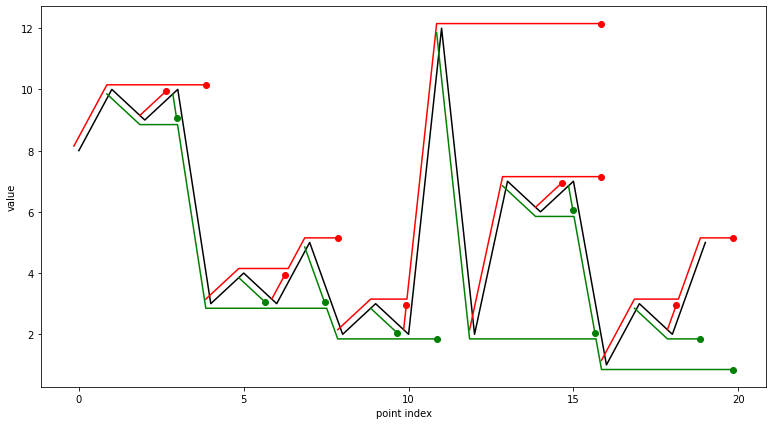

In [6]:
plt.plot(data, c='black')

drops_top = make_droplets(data, 1)
for drop in drops_top:
  points = np.array(drop['points'])
  # Offset diagonally by a small value to display next to original data
  # The following line repeats (or tiles) the [-0.15, 0.15] vector vertically to match number of points
  points = points + np.tile(np.array([-0.15, 0.15]), (points.shape[0], 1))
  plt.plot(points[:,0], points[:,1], c='red')
  plt.scatter(points[-1, 0], points[-1, 1], c='red')

drops_bottom = make_droplets(data, -1)
for drop in drops_bottom:
  points = np.array(drop['points'])
  points = points + np.tile(np.array([-0.15, -0.15]), (points.shape[0], 1))
  plt.plot(points[:,0], points[:,1], c='green')
  plt.scatter(points[-1, 0], points[-1, 1], c='green')

plt.ylabel('value')
plt.xlabel('point index')
plt.xticks([0, 5, 10, 15, 20])
plt.show()

In [7]:
drops_all = drops_top + drops_bottom
halfcycle_counts = {}
for d in drops_all:
  t = (d['from'], d['to'])
  if t in halfcycle_counts:
    halfcycle_counts[t] += 1
  else:
    halfcycle_counts[t] = 1

In [8]:
table_rows = [ '| From\\To | ' + ' | '.join([str(n + 1) for n in range(numlevels)]),
'| --: '*(numlevels + 1) + '|' ]
for m in reversed(range(numlevels)):
  row = '| **' + str(m+1) + '** |'
  for n in range(numlevels):
    if m == n:
      row += ' X |'
    elif (m+1, n+1) in halfcycle_counts:
      if (n+1, m+1) in halfcycle_counts:
        row += ' ' + str(halfcycle_counts[(m+1, n+1)]) + '|'
      else:
        row += ' [' + str(halfcycle_counts[(m+1, n+1)]) + ']|'
    else:
      row += ' |'
  table_rows.append(row)

table = '\n'.join(table_rows)
display(Markdown(table))

| From\To | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12
| --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| **12** | [1]| | | | | | | | | | | X |
| **11** | | | | | | | | | | | X | |
| **10** | | [1]| | | | | | | 1| X | | |
| **9** | | | | | | | | | X | 1| | |
| **8** | | | | | | | | X | | [1]| | |
| **7** | | 1| | | | 1| X | | | | | |
| **6** | | | | | | X | 1| | | | | |
| **5** | | | 1| | X | | | | | | | |
| **4** | | | 1| X | | | | | | | | |
| **3** | | 2| X | 1| 1| | | | | | | |
| **2** | | X | 2| | | | 1| | | | | [1]|
| **1** | X | | | | [1]| | | | | | | |

In [9]:
print('data_length - 1 = transfer_count = drops_top_count + drops_bottom_count')
print(f'{len(data)} - 1 = {len(transfers)} = {len(drops_top)} + {len(drops_bottom)}')

data_length - 1 = transfer_count = drops_top_count + drops_bottom_count
20 - 1 = 19 = 10 + 9
